In [108]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import os
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import json
import time
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
from sklearn import tree
sns.set()

In [66]:
#Obtain list of S&P100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []
ticker_to_name = {}

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    ticker_to_name[ticker] = rows.findAll('td')[1].text.strip()
    tickers.append(ticker)
    
ticker_to_sector = {}
for ticker in tickers:
    print(ticker)
    try:
        sector = yf.Ticker(ticker).info['sector']
        print(sector)
        ticker_to_sector[ticker] = sector
        clear_output(wait = True)
    except:
        ticker_to_sector[ticker] = 'Misc'
    clear_output(wait = True)

ticker_to_sector

{'AAPL': 'Technology',
 'ABBV': 'Healthcare',
 'ABT': 'Healthcare',
 'ACN': 'Technology',
 'ADBE': 'Technology',
 'AIG': 'Financial Services',
 'AMGN': 'Healthcare',
 'AMT': 'Real Estate',
 'AMZN': 'Consumer Cyclical',
 'AVGO': 'Technology',
 'AXP': 'Financial Services',
 'BA': 'Industrials',
 'BAC': 'Financial Services',
 'BIIB': 'Healthcare',
 'BK': 'Financial Services',
 'BKNG': 'Consumer Cyclical',
 'BLK': 'Financial Services',
 'BMY': 'Healthcare',
 'BRK.B': 'Misc',
 'C': 'Financial Services',
 'CAT': 'Industrials',
 'CHTR': 'Communication Services',
 'CL': 'Consumer Defensive',
 'CMCSA': 'Communication Services',
 'COF': 'Financial Services',
 'COP': 'Energy',
 'COST': 'Consumer Defensive',
 'CRM': 'Technology',
 'CSCO': 'Technology',
 'CVS': 'Healthcare',
 'CVX': 'Energy',
 'DD': 'Basic Materials',
 'DHR': 'Healthcare',
 'DIS': 'Communication Services',
 'DOW': 'Basic Materials',
 'DUK': 'Utilities',
 'EMR': 'Industrials',
 'EXC': 'Utilities',
 'F': 'Consumer Cyclical',
 'FB': '

In [67]:
all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

#Extract data from Yahoo Finance
for i in tickers:
    try:
        print(i)
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(2000,1,1), end = (dt.date.today() - timedelta(days=1)))
        test_data['Symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
    except:
        no_data.append(i)

    clear_output(wait = True)

In [68]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol
Date,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL
...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM


In [69]:
all_data['Sector'] = all_data.apply(lambda row: ticker_to_sector[row['Symbol']], axis=1)

In [70]:
def set_target_var(rfc_data, num_days):
    """
    """
    future_name = "Close_Future_" + str((num_days - 1))
    rfc_data[future_name] = rfc_data.groupby('Symbol')['Close'].transform(
        lambda x: x.shift(-(num_days - 1)))
    print('Done')
    rfc_data['Target'] = ((rfc_data[future_name] - rfc_data['Open'])/(rfc_data['Open']) * 100).shift(-1)
    rfc_data['Target_Direction'] = np.where(rfc_data['Target']>0,1,0)
    print('Done')
    rfc_data = rfc_data.dropna().copy()
    clear_output(wait = True)
    return rfc_data

In [71]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector
Date,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology
...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy


In [72]:
all_data['Return'] = all_data['Close'].pct_change()

In [73]:
all_data.reset_index(inplace=True)

In [74]:
# Calculating SMA for 8 and 20 day period along with the ratio

all_data['SMA_8'] = all_data['Close'].transform(lambda x: x.rolling(window = 8).mean())
all_data['SMA_20'] = all_data['Close'].transform(lambda x: x.rolling(window = 20).mean())
all_data['SMA_ratio'] = all_data['SMA_20'] / all_data['SMA_8']
all_data.set_index('Date', inplace=True)

In [75]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,SMA_20,SMA_ratio
Date,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,56.3550,1.002825
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,56.2535,1.004684
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,56.2040,1.005079


In [76]:
# SMA Volume Ratio
all_data['SMA8_Volume'] = all_data.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window = 8).mean())
all_data['SMA20_Volume'] = all_data.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window = 20).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA8_Volume']/all_data['SMA20_Volume']
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,SMA_20,SMA_ratio,SMA8_Volume,SMA20_Volume,SMA_Volume_Ratio
Date,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,56.3550,1.002825,21315300.0,21964160.0,0.970458
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,56.2535,1.004684,19819387.5,21057025.0,0.941224
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,56.2040,1.005079,19322925.0,20963735.0,0.921731


In [77]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [78]:
# ATR

all_data['prev_close'] = all_data.groupby('Symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['Symbol'].unique():
    TR_data = all_data[all_data.Symbol == i].copy()
    all_data.loc[all_data.Symbol==i,'ATR_8'] = Wilder(TR_data['TR'], 8)
    all_data.loc[all_data.Symbol==i,'ATR_20'] = Wilder(TR_data['TR'], 20)

all_data['ATR_Ratio'] = all_data['ATR_8'] / all_data['ATR_20']
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,SMA_20,SMA_ratio,SMA8_Volume,SMA20_Volume,SMA_Volume_Ratio,prev_close,TR,ATR_8,ATR_20,ATR_Ratio
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,NaN,NaN,NaN,NaN,NaN,0.999442,0.095982,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,NaN,NaN,NaN,NaN,NaN,0.915179,0.071987,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,NaN,NaN,NaN,NaN,NaN,0.928571,0.107143,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,NaN,NaN,NaN,NaN,NaN,0.848214,0.053571,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,56.3550,1.002825,21315300.0,21964160.0,0.970458,55.270000,0.759998,1.267343,1.430721,0.885807
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,56.2535,1.004684,19819387.5,21057025.0,0.941224,55.570000,0.850002,1.215176,1.401685,0.866939
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,56.2040,1.005079,19322925.0,20963735.0,0.921731,55.680000,0.950001,1.182029,1.379101,0.857101


In [79]:
#ADX

all_data['prev_high'] = all_data.groupby('Symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('Symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['Symbol'].unique():
    ADX_data = all_data[all_data.Symbol == i].copy()
    all_data.loc[all_data.Symbol==i,'+DM_8'] = Wilder(ADX_data['+DM'], 8)
    all_data.loc[all_data.Symbol==i,'-DM_8'] = Wilder(ADX_data['-DM'], 8)
    all_data.loc[all_data.Symbol==i,'+DM_20'] = Wilder(ADX_data['+DM'], 20)
    all_data.loc[all_data.Symbol==i,'-DM_20'] = Wilder(ADX_data['-DM'], 20)

all_data['+DI_8'] = (all_data['+DM_8']/all_data['ATR_8'])*100
all_data['-DI_8'] = (all_data['-DM_8']/all_data['ATR_8'])*100
all_data['+DI_20'] = (all_data['+DM_20']/all_data['ATR_20'])*100
all_data['-DI_20'] = (all_data['-DM_20']/all_data['ATR_20'])*100

all_data['DX_8'] = (np.round(abs(all_data['+DI_8'] - all_data['-DI_8'])/(all_data['+DI_8'] + all_data['-DI_8']) * 100))

all_data['DX_20'] = (np.round(abs(all_data['+DI_20'] - all_data['-DI_20'])/(all_data['+DI_20'] + all_data['-DI_20']) * 100))

for i in all_data['Symbol'].unique():
    ADX_data = all_data[all_data.Symbol == i].copy()
    all_data.loc[all_data.Symbol==i,'ADX_8'] = Wilder(ADX_data['DX_8'], 8)
    all_data.loc[all_data.Symbol==i,'ADX_20'] = Wilder(ADX_data['DX_20'], 20)

all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,+DM_20,-DM_20,+DI_8,-DI_8,+DI_20,-DI_20,DX_8,DX_20,ADX_8,ADX_20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,0.314106,0.336474,14.053123,23.698556,21.954390,23.517823,26.0,3.0,21.113448,13.853805
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,0.315901,0.319651,16.424698,21.626445,22.537222,22.804745,14.0,1.0,20.224267,13.211114
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,0.317106,0.303668,18.370139,19.453789,22.993666,22.019287,3.0,2.0,18.071234,12.650559


In [80]:
#Stochastic Oscillators


all_data['Lowest_8D'] = all_data.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = 8).min())
all_data['High_8D'] = all_data.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = 8).max())
all_data['Lowest_20D'] = all_data.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = 20).min())
all_data['High_20D'] = all_data.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = 20).max())

all_data['Stochastic_8'] = ((all_data['Close'] - all_data['Lowest_8D'])/(all_data['High_8D'] - all_data['Lowest_8D']))*100
all_data['Stochastic_20'] = ((all_data['Close'] - all_data['Lowest_20D'])/(all_data['High_20D'] - all_data['Lowest_20D']))*100

all_data['Stochastic_%D_8'] = all_data['Stochastic_8'].rolling(window = 8).mean()
all_data['Stochastic_%D_20'] = all_data['Stochastic_8'].rolling(window = 20).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_8']/all_data['Stochastic_%D_20']

all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,ADX_20,Lowest_8D,High_8D,Lowest_20D,High_20D,Stochastic_8,Stochastic_20,Stochastic_%D_8,Stochastic_%D_20,Stochastic_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,13.853805,54.299999,58.009998,54.299999,58.009998,34.231827,34.231827,45.556867,46.334706,0.983213
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,13.211114,54.299999,57.680000,54.299999,58.009998,40.828421,37.196803,41.114182,45.289007,0.907818
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,12.650559,54.299999,57.680000,54.299999,58.009998,62.426034,56.873346,40.826681,45.147034,0.904305


In [81]:
#RSI 
all_data['Diff'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_8up'] = all_data.groupby('Symbol')['Up'].transform(lambda x: x.rolling(window=8).mean())
all_data['avg_8down'] = all_data.groupby('Symbol')['Down'].transform(lambda x: x.rolling(window=8).mean())

all_data['avg_20up'] = all_data.groupby('Symbol')['Up'].transform(lambda x: x.rolling(window=20).mean())
all_data['avg_20down'] = all_data.groupby('Symbol')['Down'].transform(lambda x: x.rolling(window=20).mean())

all_data['RS_8'] = all_data['avg_8up'] / all_data['avg_8down']
all_data['RS_20'] = all_data['avg_20up'] / all_data['avg_20down']

all_data['RSI_8'] = 100 - (100/(1+all_data['RS_8']))
all_data['RSI_20'] = 100 - (100/(1+all_data['RS_20']))

all_data['RSI_ratio'] = all_data['RSI_8']/all_data['RSI_20']
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,Down,avg_8up,avg_8down,avg_20up,avg_20down,RS_8,RS_20,RSI_8,RSI_20,RSI_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,0.084263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,0.080357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,0.000000,0.32750,0.3450,0.3085,0.3390,0.949276,0.910029,48.698890,47.644783,1.022124
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,0.000000,0.14000,0.3450,0.2375,0.3390,0.405797,0.700590,28.865972,41.196876,0.700684
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,0.000000,0.23125,0.3025,0.2740,0.3235,0.764463,0.846986,43.325525,45.857731,0.944781


In [82]:
#MACD
all_data['8Ewm'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=8, adjust=False).mean())
all_data['20Ewm'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
all_data['MACD'] = all_data['20Ewm'] - all_data['8Ewm']
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,avg_20up,avg_20down,RS_8,RS_20,RSI_8,RSI_20,RSI_ratio,8Ewm,20Ewm,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999442,0.999442,0.000000
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.980717,0.991417,0.010700
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969129,0.985432,0.016303
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.942259,0.972363,0.030104
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.930289,0.964366,0.034077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,0.3085,0.3390,0.949276,0.910029,48.698890,47.644783,1.022124,55.894817,56.245098,0.350281
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,0.2375,0.3390,0.405797,0.700590,28.865972,41.196876,0.700684,55.847080,56.191279,0.344199
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,0.2740,0.3235,0.764463,0.846986,43.325525,45.857731,0.944781,55.972173,56.212110,0.239937


In [83]:
#Bollinger Bands
all_data['20MA'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=20).mean())
all_data['SD'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=20).std())
all_data['upperband'] = all_data['20MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['20MA'] - 2*all_data['SD']
all_data['Middleband'] = (all_data['upperband'] + all_data['lowerband'])/2
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,RSI_20,RSI_ratio,8Ewm,20Ewm,MACD,20MA,SD,upperband,lowerband,Middleband
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,NaN,0.999442,0.999442,0.000000,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,NaN,NaN,0.980717,0.991417,0.010700,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,NaN,NaN,0.969129,0.985432,0.016303,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,NaN,NaN,0.942259,0.972363,0.030104,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,NaN,NaN,0.930289,0.964366,0.034077,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,47.644783,1.022124,55.894817,56.245098,0.350281,56.3550,0.741836,57.838672,54.871328,56.3550
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,41.196876,0.700684,55.847080,56.191279,0.344199,56.2535,0.683245,57.619990,54.887010,56.2535
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,45.857731,0.944781,55.972173,56.212110,0.239937,56.2040,0.629564,57.463129,54.944871,56.2040


In [84]:
#ROC
all_data['RC'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.pct_change(periods = 20)) 
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,RSI_ratio,8Ewm,20Ewm,MACD,20MA,SD,upperband,lowerband,Middleband,RC
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.856227,AAPL,Technology,NaN,NaN,...,NaN,0.999442,0.999442,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.784038,AAPL,Technology,-0.084310,NaN,...,NaN,0.980717,0.991417,0.010700,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.795511,AAPL,Technology,0.014634,NaN,...,NaN,0.969129,0.985432,0.016303,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.726669,AAPL,Technology,-0.086538,NaN,...,NaN,0.942259,0.972363,0.030104,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.761090,AAPL,Technology,0.047368,NaN,...,NaN,0.930289,0.964366,0.034077,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23,55.939999,55.180000,55.270000,55.570000,15337900.0,55.570000,XOM,Energy,0.005428,56.19625,...,1.022124,55.894817,56.245098,0.350281,56.3550,0.741836,57.838672,54.871328,56.3550,-0.010858
2021-04-26,56.290001,55.439999,55.470001,55.680000,16083800.0,55.680000,XOM,Energy,0.001979,55.99125,...,0.700684,55.847080,56.191279,0.344199,56.2535,0.683245,57.619990,54.887010,56.2535,-0.035176
2021-04-27,56.630001,55.810001,56.009998,56.410000,19278600.0,56.410000,XOM,Energy,0.013111,55.92000,...,0.944781,55.972173,56.212110,0.239937,56.2040,0.629564,57.463129,54.944871,56.2040,-0.017247


In [85]:
all_data = set_target_var(all_data, 14)
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,MACD,20MA,SD,upperband,lowerband,Middleband,RC,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,1.046875,1.005022,1.013951,1.023438,3.689616e+08,0.876784,AAPL,Technology,0.012141,1.015224,...,-0.013830,0.996770,0.047869,1.092508,0.901032,0.996770,0.104819,1.116071,3.742750,1
2000-03-01,1.179129,1.058036,1.058594,1.163504,1.077003e+09,0.996780,AAPL,Technology,0.136859,1.032453,...,-0.031446,1.010191,0.054962,1.120116,0.900267,1.010191,0.299875,1.098214,6.249999,1
2000-03-02,1.142299,1.077567,1.133929,1.089286,3.112592e+08,0.933196,AAPL,Technology,-0.063789,1.044451,...,-0.033753,1.020543,0.048743,1.118028,0.923057,1.020543,0.234662,1.204799,15.465475,1
2000-03-03,1.144950,1.071429,1.114955,1.142857,3.233664e+08,0.979091,AAPL,Technology,0.049180,1.060285,...,-0.041464,1.031564,0.050287,1.132138,0.930990,1.031564,0.238960,1.287388,12.152778,1
2000-03-06,1.152902,1.116071,1.125000,1.122210,2.105600e+08,0.961402,AAPL,Technology,-0.018066,1.070818,...,-0.043391,1.039460,0.051550,1.142560,0.936360,1.039460,0.163773,1.261719,9.688581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,2.326480e+07,56.500000,XOM,Energy,-0.015508,56.755000,...,0.095633,58.159500,2.207116,62.573733,53.745268,58.159500,-0.072706,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,1.892630e+07,56.340000,XOM,Energy,-0.002832,56.755000,...,0.148380,57.933000,2.145909,62.224819,53.641182,57.933000,-0.074421,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,2.238500e+07,56.590000,XOM,Energy,0.004437,56.806250,...,0.150612,57.766000,2.112014,61.990029,53.541972,57.766000,-0.055732,55.680000,0.858215,1


In [86]:
#Winsorizing the indicators
Target_variables = ['SMA_ratio','ATR_8','ATR_20','ATR_Ratio', 'SMA_Volume_Ratio',
                       'ADX_8','ADX_20','Stochastic_8','Stochastic_20','Stochastic_Ratio',
                      'RSI_8','RSI_20','RSI_ratio','MACD', 'Middleband']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])
    

In [87]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,MACD,20MA,SD,upperband,lowerband,Middleband,RC,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,1.046875,1.005022,1.013951,1.023438,3.689616e+08,0.876784,AAPL,Technology,0.012141,1.015224,...,-0.013830,0.996770,0.047869,1.092508,0.901032,18.5630,0.104819,1.116071,3.742750,1
2000-03-01,1.179129,1.058036,1.058594,1.163504,1.077003e+09,0.996780,AAPL,Technology,0.136859,1.032453,...,-0.031446,1.010191,0.054962,1.120116,0.900267,18.5630,0.299875,1.098214,6.249999,1
2000-03-02,1.142299,1.077567,1.133929,1.089286,3.112592e+08,0.933196,AAPL,Technology,-0.063789,1.044451,...,-0.033753,1.020543,0.048743,1.118028,0.923057,18.5630,0.234662,1.204799,15.465475,1
2000-03-03,1.144950,1.071429,1.114955,1.142857,3.233664e+08,0.979091,AAPL,Technology,0.049180,1.060285,...,-0.041464,1.031564,0.050287,1.132138,0.930990,18.5630,0.238960,1.287388,12.152778,1
2000-03-06,1.152902,1.116071,1.125000,1.122210,2.105600e+08,0.961402,AAPL,Technology,-0.018066,1.070818,...,-0.043391,1.039460,0.051550,1.142560,0.936360,18.5630,0.163773,1.261719,9.688581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,2.326480e+07,56.500000,XOM,Energy,-0.015508,56.755000,...,0.095633,58.159500,2.207116,62.573733,53.745268,58.1595,-0.072706,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,1.892630e+07,56.340000,XOM,Energy,-0.002832,56.755000,...,0.148380,57.933000,2.145909,62.224819,53.641182,57.9330,-0.074421,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,2.238500e+07,56.590000,XOM,Energy,0.004437,56.806250,...,0.150612,57.766000,2.112014,61.990029,53.541972,57.7660,-0.055732,55.680000,0.858215,1


In [88]:
all_data['Sector'].unique()

array(['Technology', 'Healthcare', 'Financial Services', 'Real Estate',
       'Consumer Cyclical', 'Industrials', 'Communication Services',
       'Consumer Defensive', 'Energy', 'Basic Materials', 'Utilities',
       'Misc'], dtype=object)

In [89]:
sectors = list(all_data['Sector'].unique())
sectors

['Technology',
 'Healthcare',
 'Financial Services',
 'Real Estate',
 'Consumer Cyclical',
 'Industrials',
 'Communication Services',
 'Consumer Defensive',
 'Energy',
 'Basic Materials',
 'Utilities',
 'Misc']

In [90]:
sector_dict = {}
for i in range(len(sectors)):
    sector_dict[sectors[i]] = i
sector_dict

{'Technology': 0,
 'Healthcare': 1,
 'Financial Services': 2,
 'Real Estate': 3,
 'Consumer Cyclical': 4,
 'Industrials': 5,
 'Communication Services': 6,
 'Consumer Defensive': 7,
 'Energy': 8,
 'Basic Materials': 9,
 'Utilities': 10,
 'Misc': 11}

In [91]:
returns = all_data[['Symbol','Return']].copy()
returns['Date'] = returns.index.copy()

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'Date', columns = 'Symbol', values = 'Return').dropna()

#Transpose the data to get companies on the index level
companies_returns = transposed.dropna().transpose()

In [92]:
companies_returns

Date,2019-05-15,2019-05-16,2019-05-17,2019-05-20,2019-05-21,2019-05-22,2019-05-23,2019-05-24,2019-05-28,2019-05-29,...,2021-03-26,2021-03-29,2021-03-30,2021-03-31,2021-04-01,2021-04-05,2021-04-06,2021-04-07,2021-04-08,2021-04-09
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.011979,-0.004400,-0.005682,-0.031270,0.019171,-0.020472,-0.017070,-0.003841,-0.004135,-0.004769,...,0.005141,0.001485,-0.012274,0.018766,0.006959,0.023577,0.002462,0.013390,0.019234,0.020252
ABBV,0.004334,0.009139,-0.000503,0.004531,0.013280,0.008778,-0.005393,-0.013432,-0.025356,0.000384,...,0.020216,0.007077,0.000562,0.013391,0.002772,-0.021931,-0.007160,-0.001613,0.008459,0.013572
ABT,0.006313,0.001176,-0.008225,-0.002633,0.003431,0.003025,-0.008261,0.017850,-0.016498,-0.000528,...,0.025367,0.001311,-0.020290,0.000752,-0.007510,0.007735,0.000918,0.001167,-0.002747,0.009350
ACN,0.010310,0.015792,0.000898,0.001178,0.005769,0.004566,-0.011752,0.003029,-0.002349,-0.004372,...,0.045270,-0.004381,-0.003542,-0.008257,0.007566,0.010024,0.001779,0.003338,0.006547,0.011567
ADBE,0.018245,0.024312,-0.013049,-0.015723,0.009512,0.013486,-0.026861,0.001896,0.012665,-0.017502,...,0.040134,0.000490,-0.008225,0.021291,0.016766,0.017131,-0.000570,0.004213,0.013032,0.008403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.004598,0.010033,0.012374,0.015837,0.008304,-0.004202,-0.006414,0.007644,-0.009946,-0.009365,...,0.013942,0.011172,-0.004080,-0.007510,0.002579,0.009777,0.004077,-0.001861,-0.023729,-0.001910
WBA,0.003043,-0.004551,-0.004381,-0.000191,0.009568,0.003412,-0.025123,0.003100,-0.000966,-0.011408,...,0.006188,0.015760,0.002460,0.036240,-0.002732,0.037443,-0.019366,-0.002154,-0.014214,-0.011133
WFC,-0.013982,0.001309,-0.004357,-0.005470,0.019362,-0.004964,-0.011714,0.013389,-0.012562,-0.002413,...,0.011705,-0.033199,0.024714,-0.008124,0.014333,-0.003785,0.009372,0.003513,0.001000,0.011741


In [93]:
all_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,MACD,20MA,SD,upperband,lowerband,Middleband,RC,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,1.046875,1.005022,1.013951,1.023438,3.689616e+08,0.876784,AAPL,Technology,0.012141,1.015224,...,-0.013830,0.996770,0.047869,1.092508,0.901032,18.5630,0.104819,1.116071,3.742750,1
2000-03-01,1.179129,1.058036,1.058594,1.163504,1.077003e+09,0.996780,AAPL,Technology,0.136859,1.032453,...,-0.031446,1.010191,0.054962,1.120116,0.900267,18.5630,0.299875,1.098214,6.249999,1
2000-03-02,1.142299,1.077567,1.133929,1.089286,3.112592e+08,0.933196,AAPL,Technology,-0.063789,1.044451,...,-0.033753,1.020543,0.048743,1.118028,0.923057,18.5630,0.234662,1.204799,15.465475,1
2000-03-03,1.144950,1.071429,1.114955,1.142857,3.233664e+08,0.979091,AAPL,Technology,0.049180,1.060285,...,-0.041464,1.031564,0.050287,1.132138,0.930990,18.5630,0.238960,1.287388,12.152778,1
2000-03-06,1.152902,1.116071,1.125000,1.122210,2.105600e+08,0.961402,AAPL,Technology,-0.018066,1.070818,...,-0.043391,1.039460,0.051550,1.142560,0.936360,18.5630,0.163773,1.261719,9.688581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-05,57.320000,56.139999,57.299999,56.500000,2.326480e+07,56.500000,XOM,Energy,-0.015508,56.755000,...,0.095633,58.159500,2.207116,62.573733,53.745268,58.1595,-0.072706,55.270000,-2.234343,0
2021-04-06,57.540001,56.259998,56.840000,56.340000,1.892630e+07,56.340000,XOM,Energy,-0.002832,56.755000,...,0.148380,57.933000,2.145909,62.224819,53.641182,57.9330,-0.074421,55.570000,-1.259087,0
2021-04-07,56.770000,56.240002,56.389999,56.590000,2.238500e+07,56.590000,XOM,Energy,0.004437,56.806250,...,0.150612,57.766000,2.112014,61.990029,53.541972,57.7660,-0.055732,55.680000,0.858215,1


In [94]:
sectors

['Technology',
 'Healthcare',
 'Financial Services',
 'Real Estate',
 'Consumer Cyclical',
 'Industrials',
 'Communication Services',
 'Consumer Defensive',
 'Energy',
 'Basic Materials',
 'Utilities',
 'Misc']

In [95]:
#Splitting time series data 
all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc[:'2019-12-31',]
test_data = all_data.loc['2020-01-01':]

In [96]:
train_data

,High,Low,Open,Close,Volume,Adj Close,Symbol,Sector,Return,SMA_8,...,MACD,20MA,SD,upperband,lowerband,Middleband,RC,Close_Future_13,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,1.046875,1.005022,1.013951,1.023438,3.689616e+08,0.876784,AAPL,Technology,0.012141,1.015224,...,-0.013830,0.996770,0.047869,1.092508,0.901032,18.5630,0.104819,1.116071,3.742750,1
2000-03-01,1.179129,1.058036,1.058594,1.163504,1.077003e+09,0.996780,AAPL,Technology,0.136859,1.032453,...,-0.031446,1.010191,0.054962,1.120116,0.900267,18.5630,0.299875,1.098214,6.249999,1
2000-03-02,1.142299,1.077567,1.133929,1.089286,3.112592e+08,0.933196,AAPL,Technology,-0.063789,1.044451,...,-0.033753,1.020543,0.048743,1.118028,0.923057,18.5630,0.234662,1.204799,15.465475,1
2000-03-03,1.144950,1.071429,1.114955,1.142857,3.233664e+08,0.979091,AAPL,Technology,0.049180,1.060285,...,-0.041464,1.031564,0.050287,1.132138,0.930990,18.5630,0.238960,1.287388,12.152778,1
2000-03-06,1.152902,1.116071,1.125000,1.122210,2.105600e+08,0.961402,AAPL,Technology,-0.018066,1.070818,...,-0.043391,1.039460,0.051550,1.142560,0.936360,18.5630,0.163773,1.261719,9.688581,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,70.500000,69.910004,70.349998,70.019997,3.979400e+06,63.758801,XOM,Energy,-0.003841,69.802501,...,-0.306003,69.244000,0.736067,70.716134,67.771866,69.2440,0.016108,69.199997,-1.567183,0
2019-12-26,70.500000,70.010002,70.190002,70.129997,8.840200e+06,63.858959,XOM,Energy,0.001571,69.915000,...,-0.315666,69.313500,0.751436,70.816372,67.810628,69.3135,0.020221,69.089996,-1.965808,0
2019-12-27,70.309998,69.879997,70.199997,69.889999,1.051610e+07,63.640423,XOM,Energy,-0.003422,69.901250,...,-0.285309,69.373000,0.747403,70.867807,67.878193,69.3730,0.017322,68.820000,-2.182906,0


Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

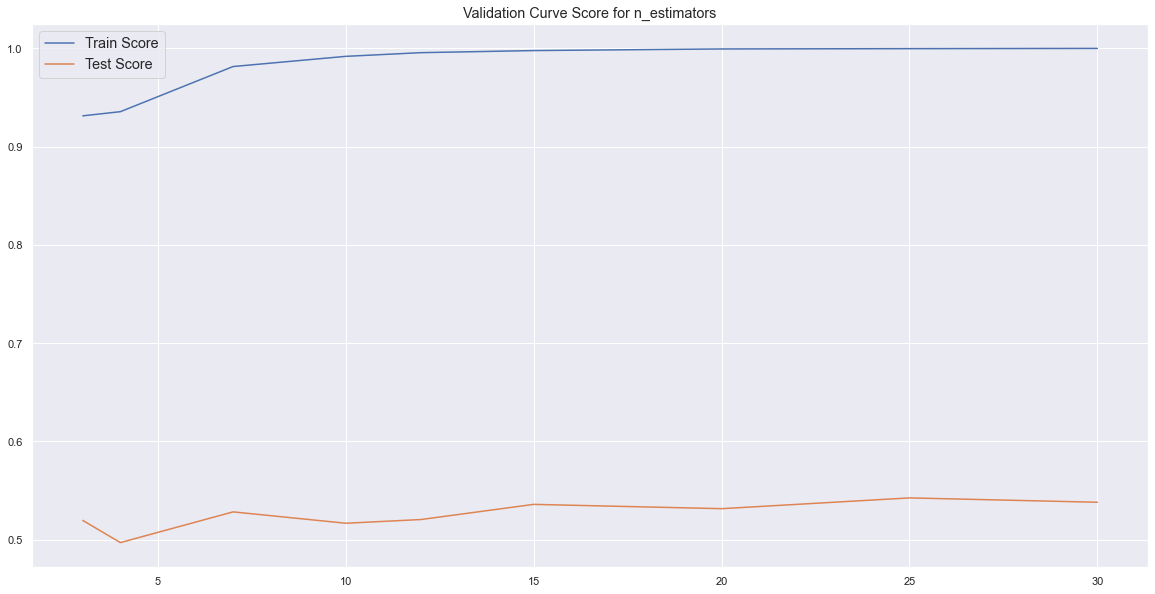

In [97]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'], 
                                param_name = 'n_estimators', 
                                param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')

In [152]:
def generate_rfc(sector_name):
    print(f'The current cluster running is: {sector_name}')
    sector_train = train_data[train_data['Sector'] == sector_name].copy()
    sector_train = sector_train.dropna().copy()
    
    X_train = sector_train.loc[:,Target_variables]
    features = X_train.columns

    Y_train = sector_train.loc[:,['Target_Direction']]
    
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
          'min_samples_split':[20, 25, 30]}
    
    rf = RandomForestClassifier()
    time_series_split = TimeSeriesSplit(n_splits = 3)
    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 10)
    
    rf_cv.fit(X_train, Y_train.values.ravel())
    
#     fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
#     tree.plot_tree(rf_cv.best_estimator_.estimators_[0],
#                    feature_names = Target_variables, 
#                    filled = True);
#     fig.savefig(f'{sector_dict[sector_name]}_tree.png')

    importances = rf_cv.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    plt.figure(1)
    plt.title(f'{sector_name} Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.savefig(f'{os.getcwd()}\\RFC_Images\\{sector_name}_RelativeImportance')
    
    fn=X_train.columns
    cn=[str(1), str(0)]
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
    tree.plot_tree(rf_cv.best_estimator_.estimators_[0],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True);
    fig.savefig(f'{os.getcwd()}\\RFC_Images\\{sector_name}_DecisionTree')
    
    file_loc = f'{os.getcwd()}\\RFC_2\\Sector_{sector_dict[sector_name]}'
    pickle.dump(rf_cv, open(file_loc, 'wb'))

The current cluster running is: Technology
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    7.6s finished


Generated RFC - Technology
The current cluster running is: Healthcare
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:   10.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   11.9s finished


Generated RFC - Healthcare
The current cluster running is: Financial Services
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:   12.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   13.2s finished


Generated RFC - Financial Services
The current cluster running is: Real Estate
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0780s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.1s finished


Generated RFC - Real Estate
The current cluster running is: Consumer Cyclical
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1490s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0461s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    7.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    7.6s finished


Generated RFC - Consumer Cyclical
The current cluster running is: Industrials
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1950s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0329s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    9.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   10.2s finished


Generated RFC - Industrials
The current cluster running is: Communication Services
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1713s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0872s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    6.1s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    7.1s finished


Generated RFC - Communication Services
The current cluster running is: Consumer Defensive
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    8.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    9.2s finished


Generated RFC - Consumer Defensive
The current cluster running is: Energy
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0893s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.9s finished


Generated RFC - Energy
The current cluster running is: Basic Materials
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0770s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    2.1s finished


Generated RFC - Basic Materials
The current cluster running is: Utilities
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0959s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    3.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    3.9s finished


Generated RFC - Utilities
The current cluster running is: Misc
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0480s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1939s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 156 out of 162 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    1.4s finished


Generated RFC - Misc


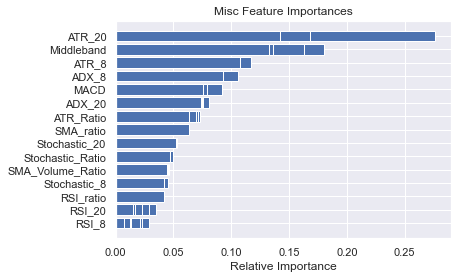

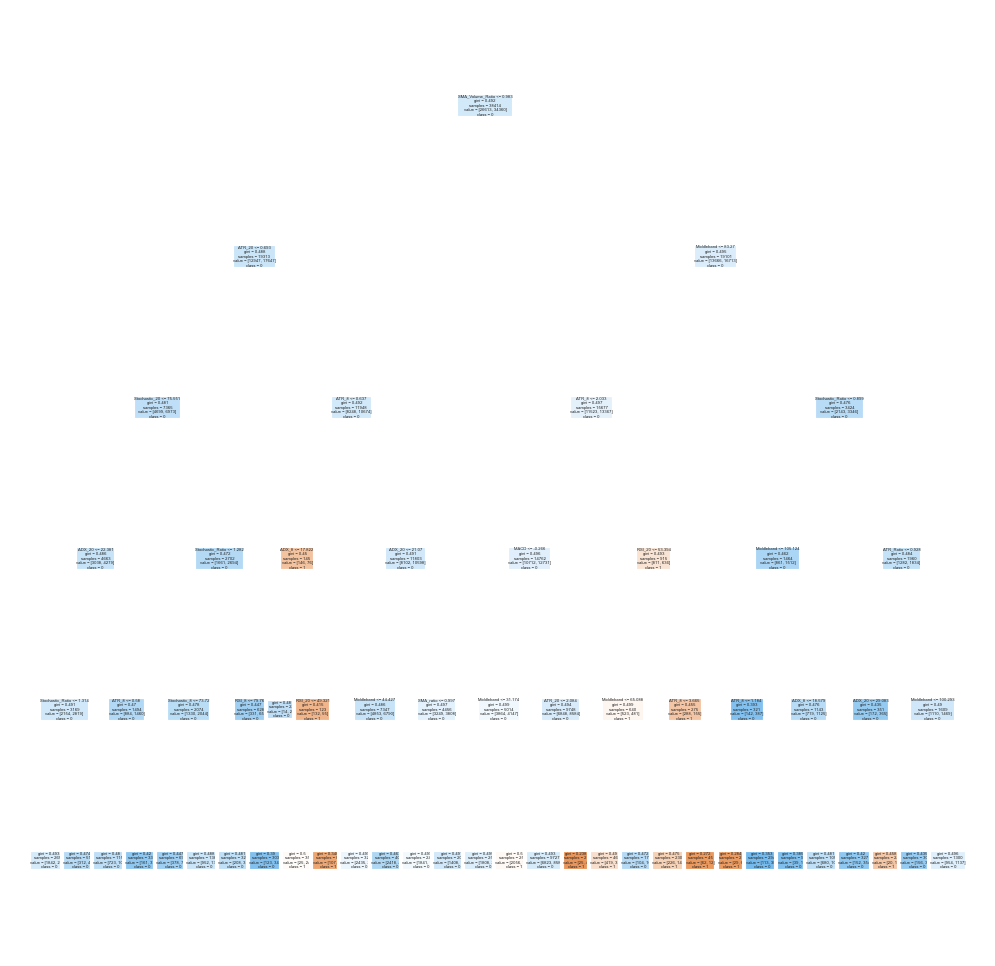

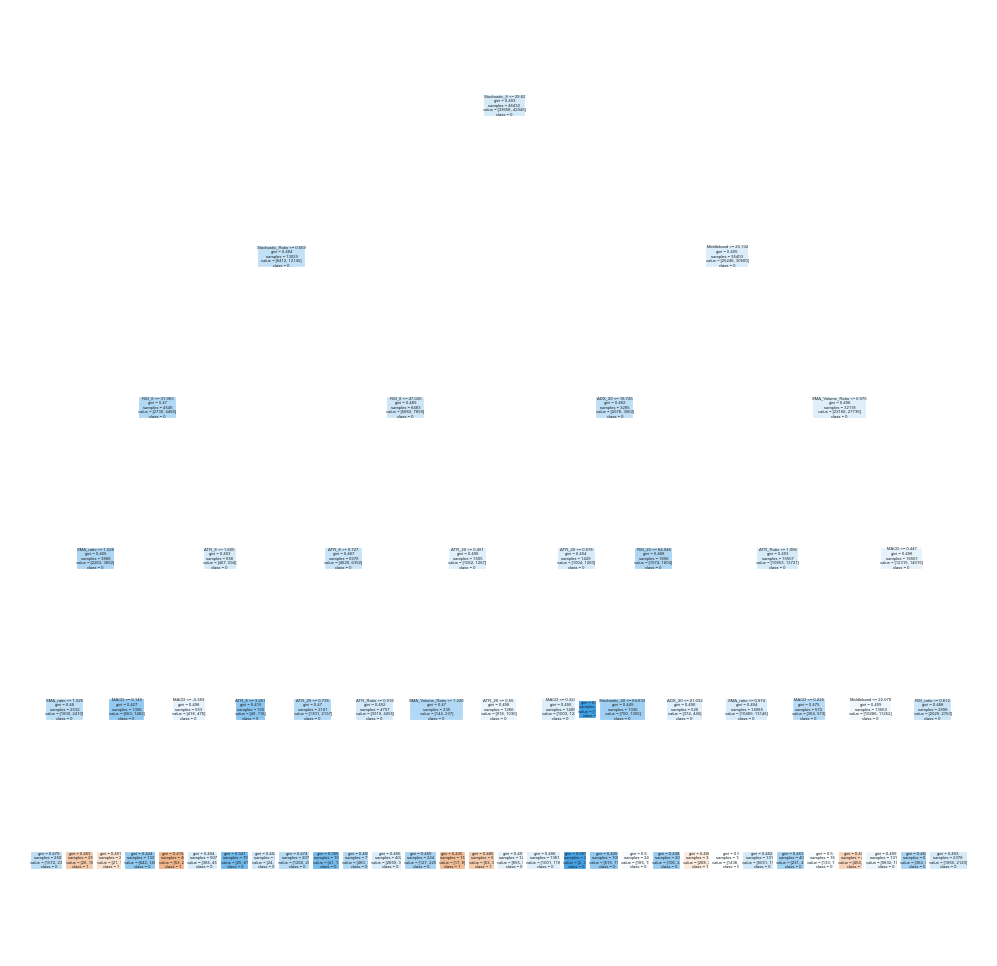

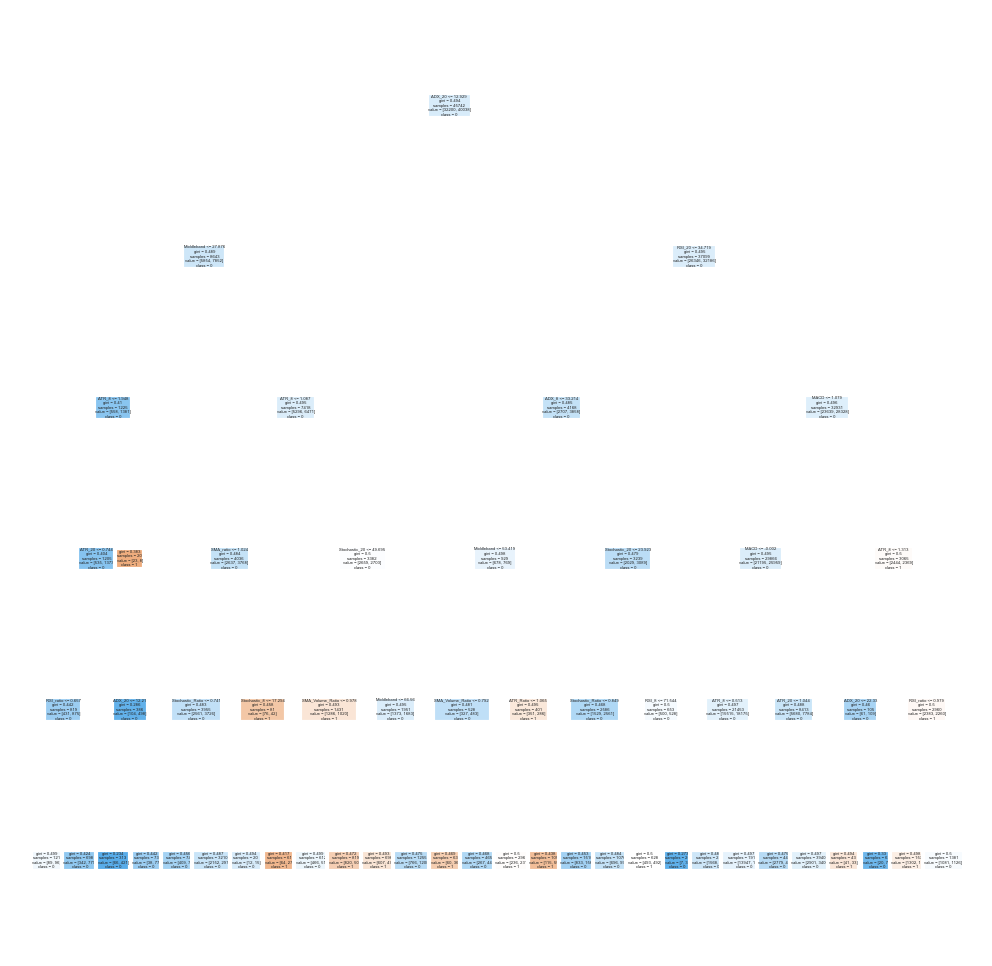

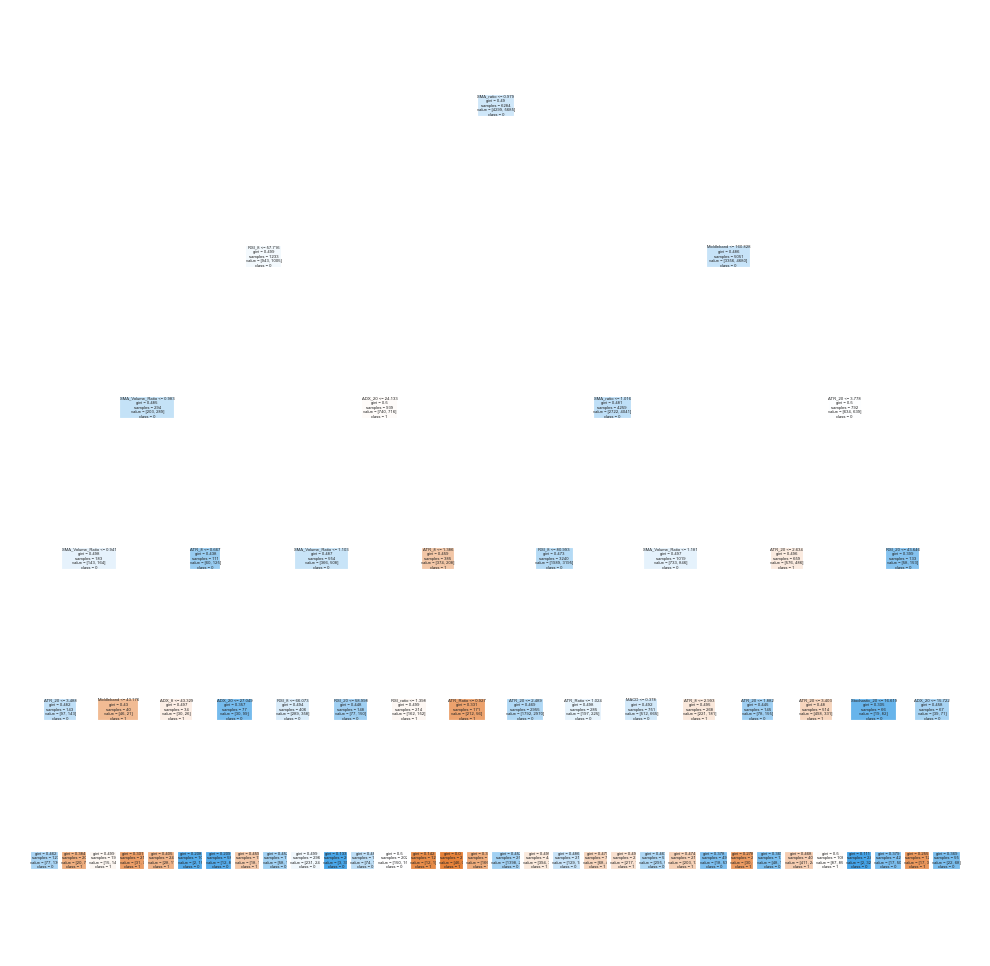

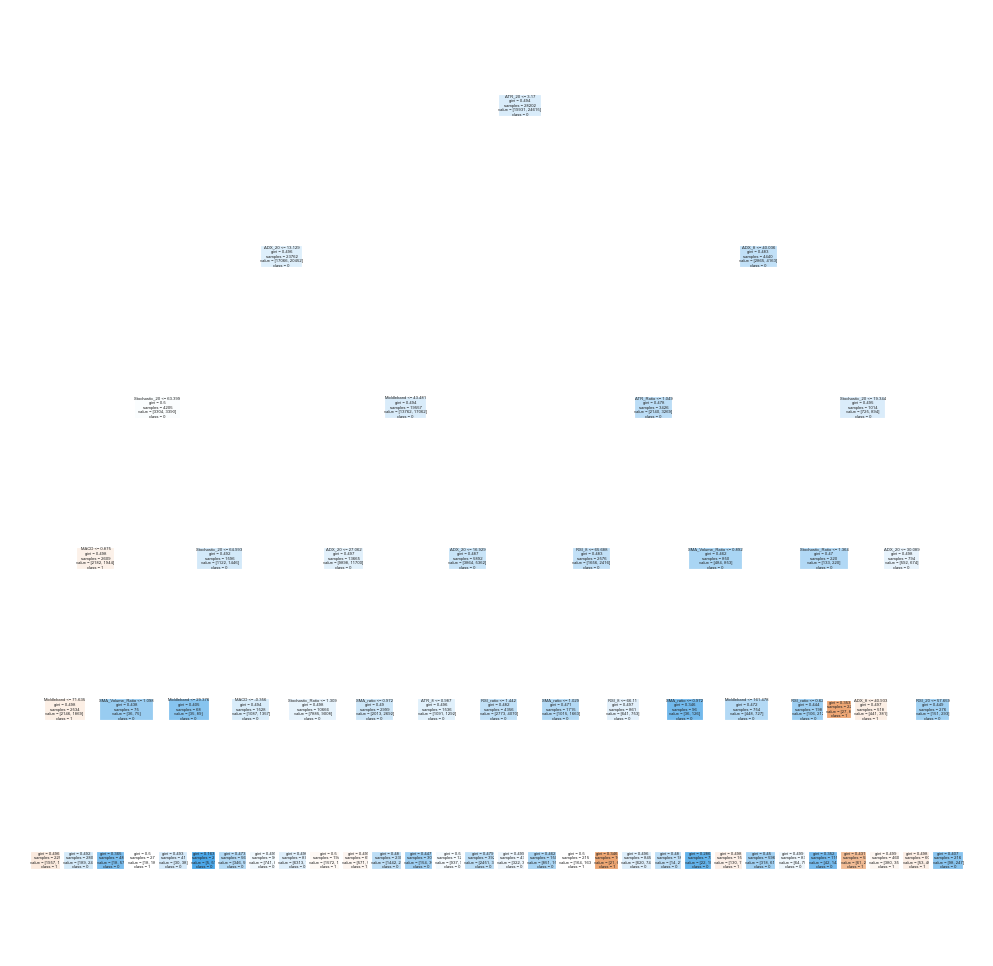

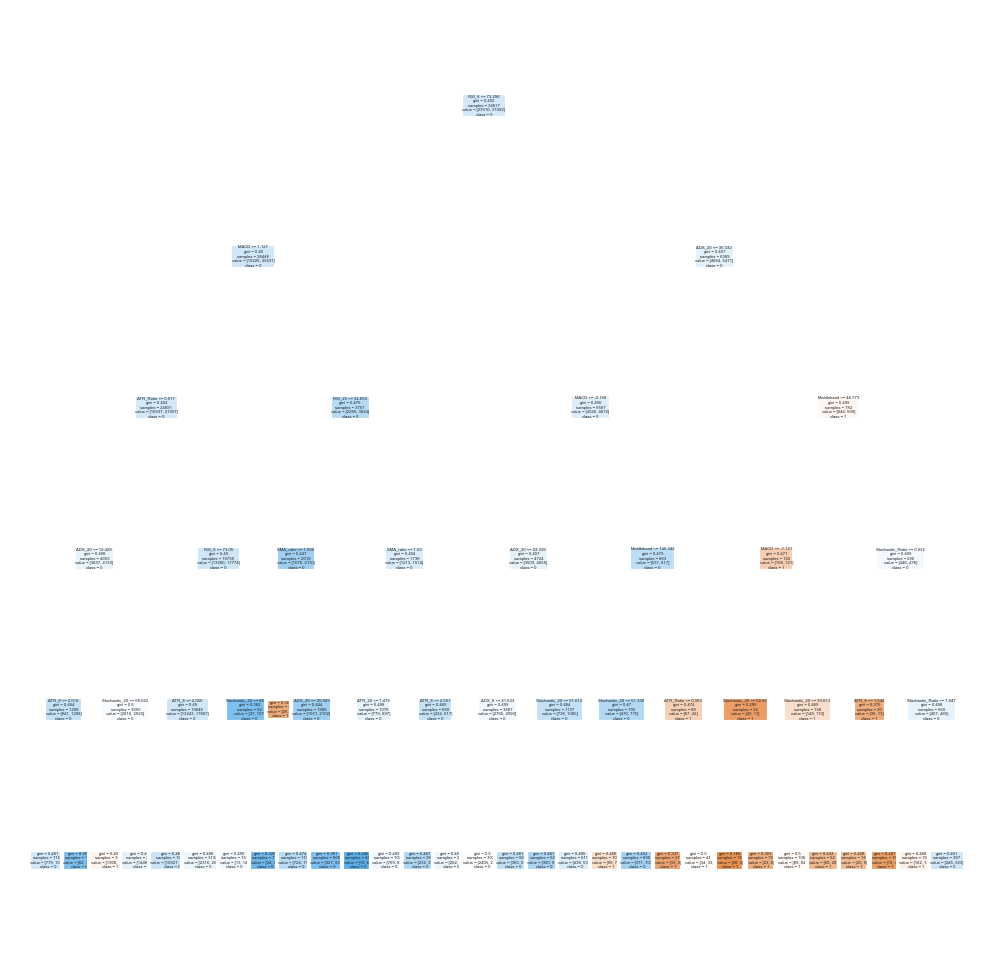

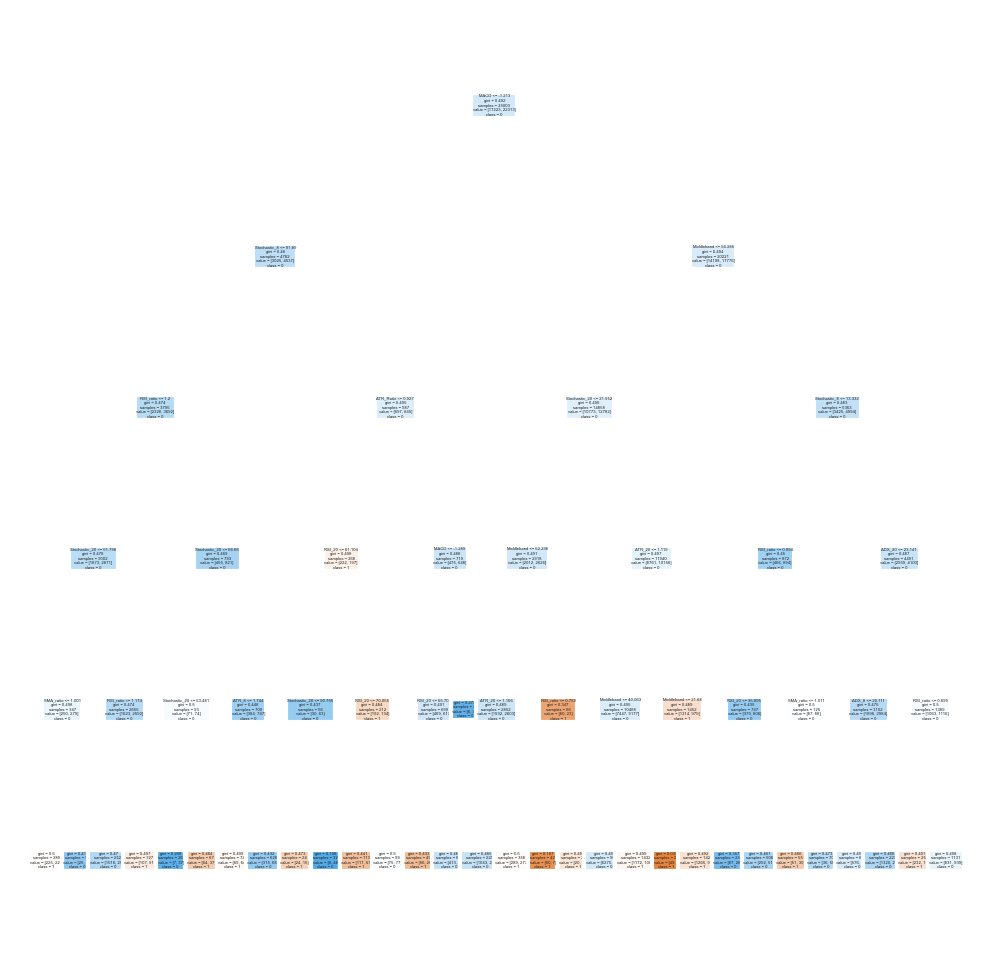

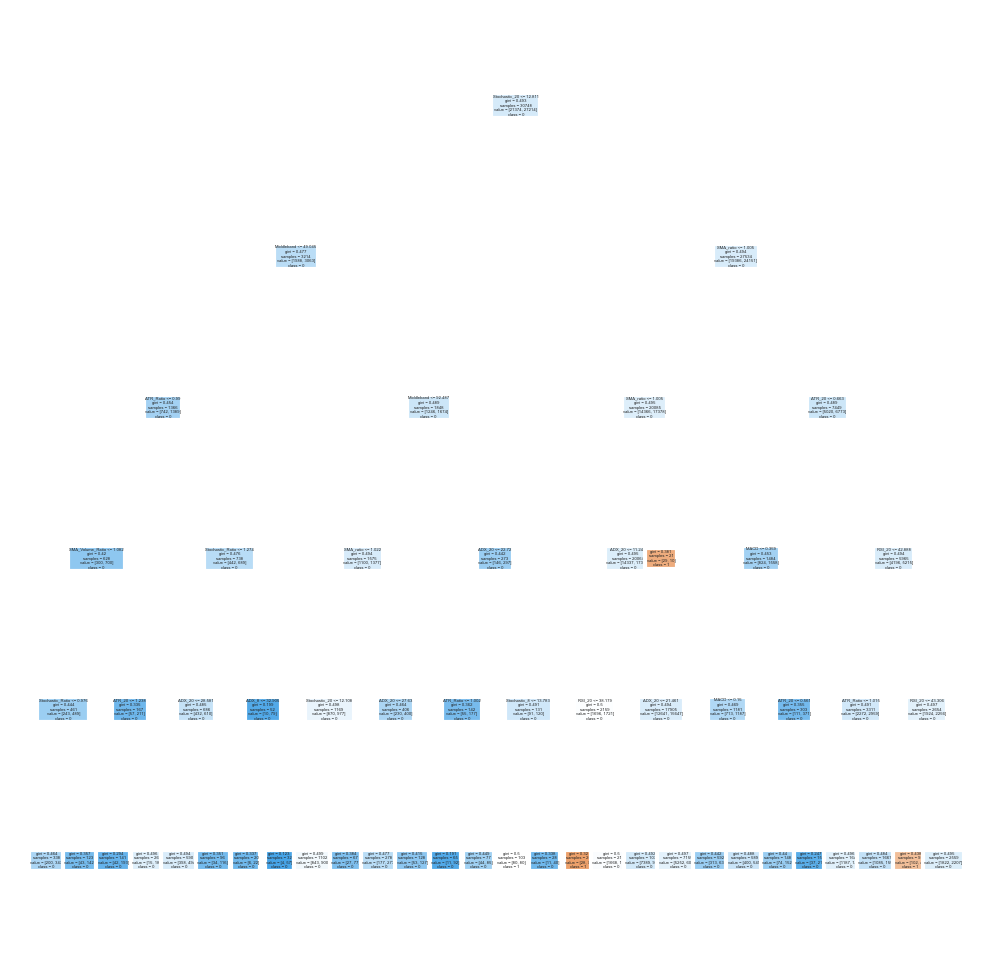

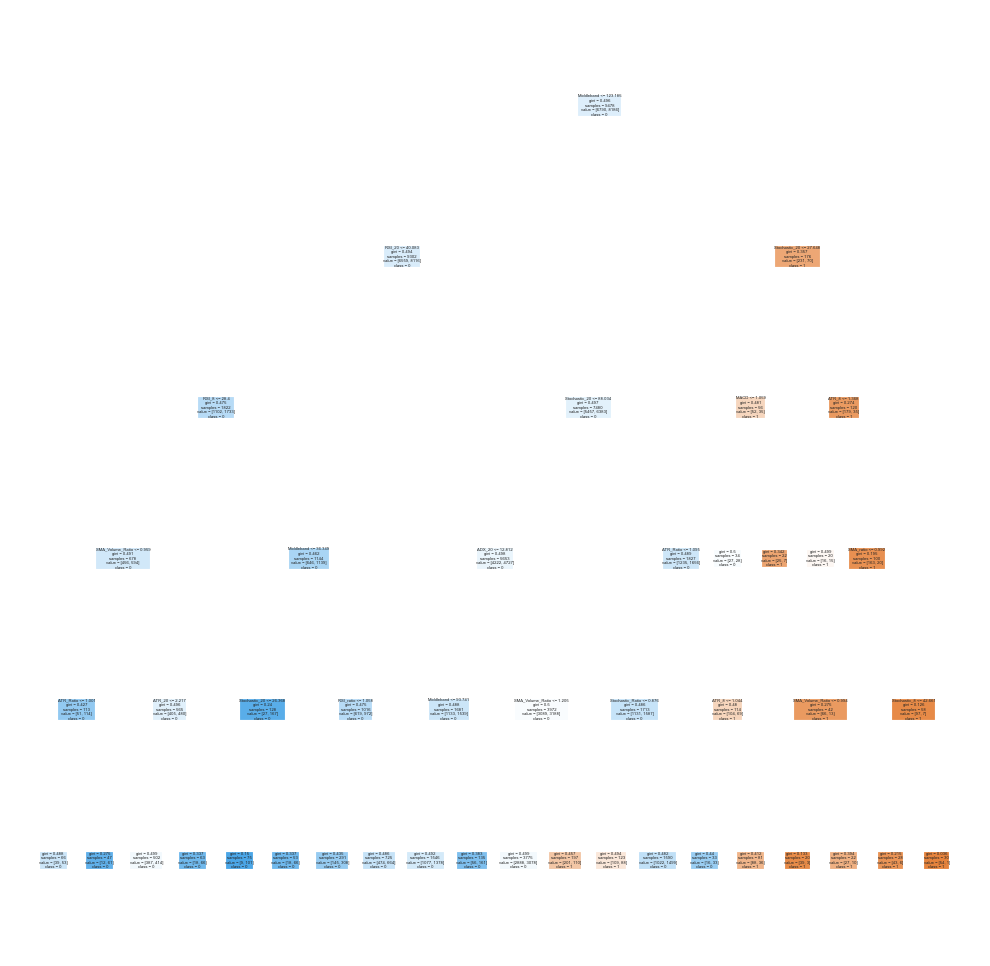

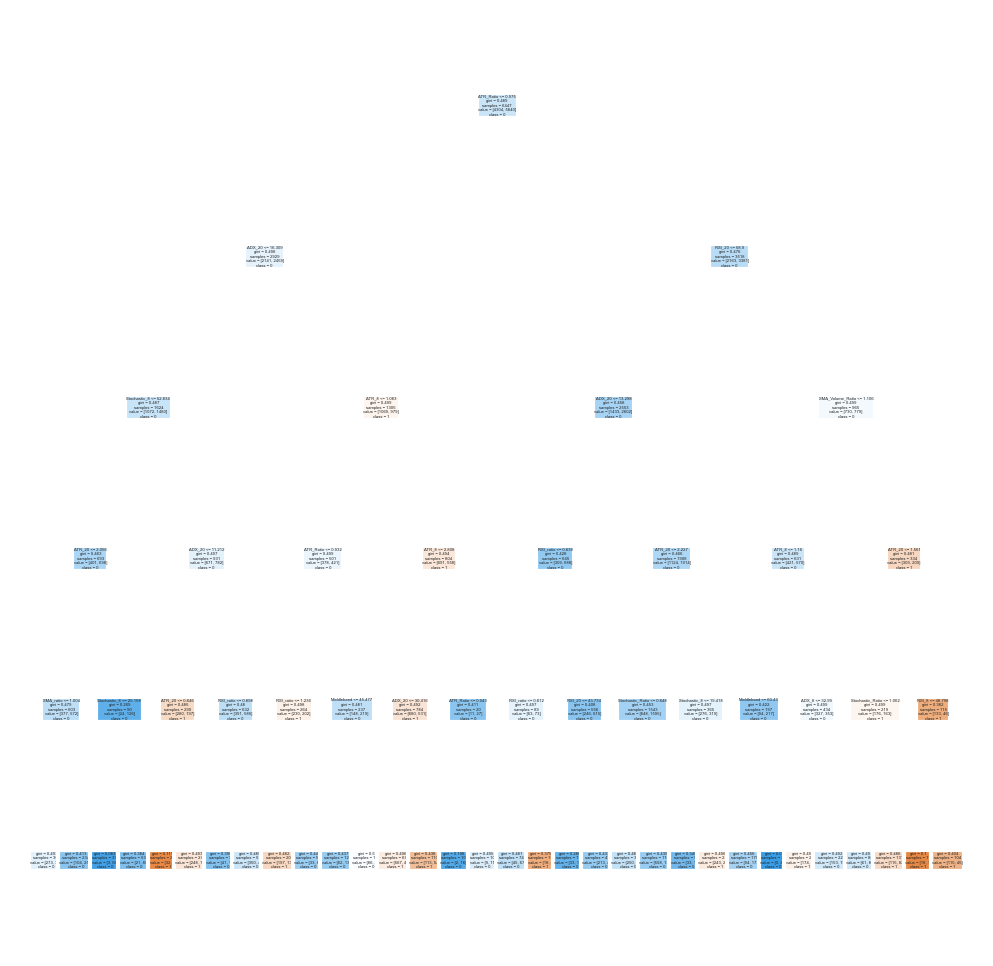

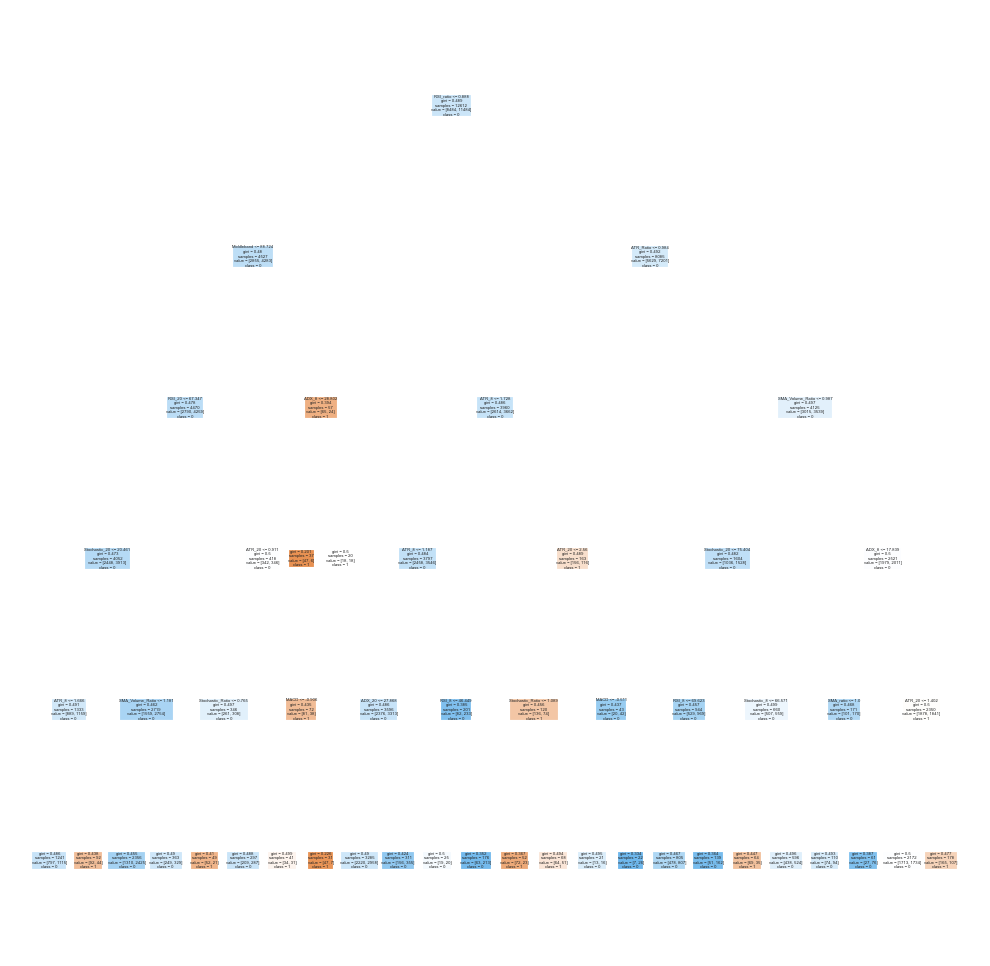

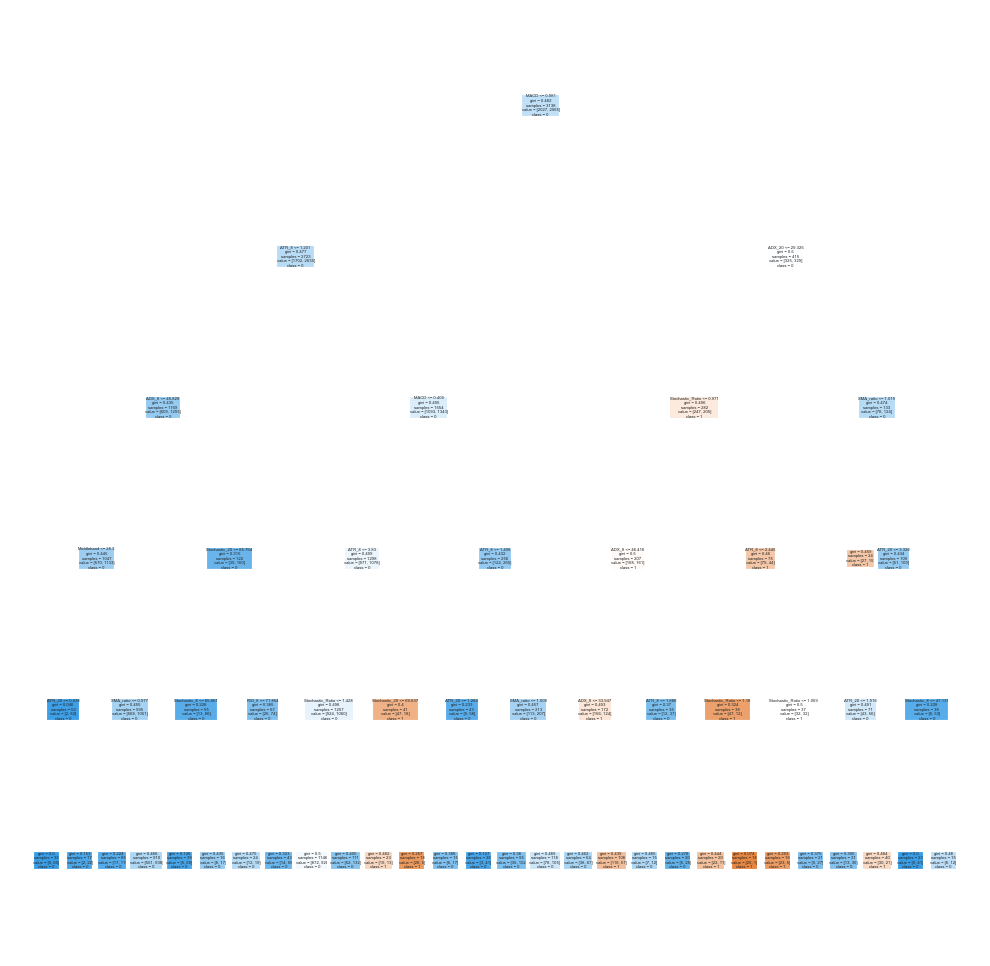

In [153]:
for sector in sectors:
    generate_rfc(sector)
    print('Generated RFC - ' + sector)

In [127]:
# Test dates list 

test_dates = []
for timestamp in list(test_data.index.unique()):
    test_dates.append(timestamp.strftime('%Y-%m-%d'))

In [147]:
train_data[Target_variables]

,SMA_ratio,ATR_8,ATR_20,ATR_Ratio,SMA_Volume_Ratio,ADX_8,ADX_20,Stochastic_8,Stochastic_20,Stochastic_Ratio,RSI_8,RSI_20,RSI_ratio,MACD,Middleband
Date,,,,,,,,,,,,,,,
2000-02-29,0.981823,0.408378,0.418321,0.925010,0.936230,17.755490,11.1977,63.819110,76.839246,0.840655,51.282046,58.562992,0.875673,-0.013830,18.5630
2000-03-01,0.978438,0.408378,0.418321,1.046062,1.091971,18.394484,11.1977,93.038056,93.627401,0.869223,72.413785,69.859619,1.036561,-0.031446,18.5630
2000-03-02,0.977109,0.408378,0.418321,1.061880,1.137588,21.595173,11.1977,60.344828,68.369355,0.908909,63.738018,64.042389,0.995247,-0.033753,18.5630
2000-03-03,0.972912,0.408378,0.418321,1.061036,1.127991,23.770776,11.1977,82.849624,85.714299,0.936487,66.666672,64.684015,1.030651,-0.041464,18.5630
2000-03-06,0.970716,0.408378,0.418321,1.019830,1.073210,26.049429,11.1977,73.087053,75.598068,0.935089,61.119281,60.826312,1.004816,-0.043391,18.5630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.991999,0.951801,1.036114,0.918626,1.119542,17.755490,11.1977,63.379934,82.781340,1.079821,46.039609,55.555513,0.828714,-0.306003,69.2440
2019-12-26,0.991397,0.894076,1.008808,0.886270,1.115114,17.755490,11.1977,70.634752,86.423739,1.114429,64.802490,56.998984,1.136906,-0.315666,69.3135
2019-12-27,0.992443,0.836066,0.979867,0.879927,1.062543,17.755490,11.1977,51.587335,78.476801,1.057341,47.808761,55.873652,0.855658,-0.285309,69.3730


In [128]:
pred = pd.DataFrame({'Date':[], 'Company':[], 'Prediction':[]})
for date in test_dates:
    day_data = test_data.loc[date]
    
    for idx, row in day_data.reset_index().iterrows():
        rf_cv = pickle.load(open(os.getcwd() + f'\\RFC_2\\Sector_{sector_dict[row.Sector]}', 'rb'))
        best_rf = rf_cv.best_estimator_
        X_test = row.loc[Target_variables]
        pred = pred.append(pd.DataFrame({'Date':[row.Date], 'Company':[row.Symbol],
                                                'Prediction':best_rf.predict_proba([X_test])[:,1]}), ignore_index = True)

In [129]:
pred['Predicted_Dir'] = np.where(pred['Prediction']>=0.505,1,0)
pred.sort_values(by=['Company', 'Date'], inplace=True)
pred.set_index(['Date', 'Company'])

,,Prediction,Predicted_Dir
Date,Company,,
2020-01-02,AAPL,0.506870,1
2020-01-03,AAPL,0.526692,1
2020-01-06,AAPL,0.513322,1
2020-01-07,AAPL,0.507858,1
2020-01-08,AAPL,0.488773,0
...,...,...,...
2021-04-05,XOM,0.578792,1
2021-04-06,XOM,0.561021,1
2021-04-07,XOM,0.538178,1


In [130]:
target_data = test_data.reset_index()[['Date', 'Symbol', 'Target_Direction', 'Target']].copy()
target_data.columns = ['Date', 'Company', 'Actual', 'Pct_Change']
target_data.set_index(['Date', 'Company'], inplace=True)

In [131]:
accuracy_pred = pd.concat([pred.set_index(['Date', 'Company']), target_data], axis=1)

In [132]:
accuracy_pred

,,Prediction,Predicted_Dir,Actual,Pct_Change
Date,Company,,,,
2020-01-02,AAPL,0.506870,1,1,7.430597
2020-01-03,AAPL,0.526692,1,1,8.346094
2020-01-06,AAPL,0.513322,1,1,3.038292
2020-01-07,AAPL,0.507858,1,1,6.908736
2020-01-08,AAPL,0.488773,0,1,5.565684
...,...,...,...,...,...
2021-04-05,XOM,0.578792,1,0,-2.234343
2021-04-06,XOM,0.561021,1,0,-1.259087
2021-04-07,XOM,0.538178,1,1,0.858215


In [133]:
y_pred = accuracy_pred['Predicted_Dir']
y_test = accuracy_pred['Actual']
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.12      0.19     13239
           1       0.59      0.88      0.70     18761

    accuracy                           0.57     32000
   macro avg       0.50      0.50      0.45     32000
weighted avg       0.52      0.57      0.49     32000

0.56615625


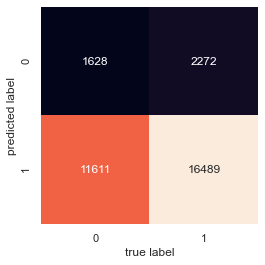

In [154]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [134]:
filtered_dates = []
for i in range(len(test_dates)):
    if i % 13 == 0:
        filtered_dates.append(test_dates[i])

In [135]:
filtered_pred = accuracy_pred.copy()
filtered_pred.reset_index(inplace=True)

In [136]:
filtered_pred = filtered_pred[filtered_pred['Date'].isin(filtered_dates)]
filtered_pred

,Date,Company,Prediction,Predicted_Dir,Actual,Pct_Change
0,2020-01-02,AAPL,0.506870,1,1,7.430597
13,2020-01-22,AAPL,0.495460,0,1,0.531571
26,2020-02-10,AAPL,0.505613,1,0,-7.660695
39,2020-02-28,AAPL,0.568387,1,0,-13.284682
52,2020-03-18,AAPL,0.559946,1,1,4.866807
...,...,...,...,...,...,...
31940,2021-01-13,XOM,0.509577,1,0,-2.226808
31953,2021-02-02,XOM,0.569510,1,1,20.644308
31966,2021-02-22,XOM,0.521176,1,1,12.713717
31979,2021-03-11,XOM,0.488741,0,0,-9.293253


In [137]:
y_pred_filt = filtered_pred['Predicted_Dir']
y_test_filt = filtered_pred['Actual']
print(classification_report(y_test_filt,y_pred_filt))
print(accuracy_score(y_test_filt, y_pred_filt))

              precision    recall  f1-score   support

           0       0.41      0.11      0.17      1080
           1       0.56      0.88      0.69      1420

    accuracy                           0.55      2500
   macro avg       0.49      0.49      0.43      2500
weighted avg       0.50      0.55      0.46      2500

0.5468


In [138]:
top_10_pred = []
for date in test_dates:
    day_pred = pd.DataFrame({'Date':[], 'Company':[], 'Prediction':[]})
    day_data = test_data.loc[date]
    
    for sector_name in sectors:
        rf_cv =  pickle.load(open(os.getcwd() + f'\\RFC_2\\Sector_{sector_dict[sector_name]}', 'rb'))
        best_rf = rf_cv.best_estimator_
        sector_data = day_data.loc[day_data['Sector'] == sector_name].copy()
        sector_data = sector_data.dropna()
        if (sector_data.shape[0]>0):
            X_test = sector_data.loc[:,Target_variables]
            day_pred = day_pred.append(pd.DataFrame({'Date':sector_data.index,
                                                                       'Company':sector_data['Symbol'],
                                                                       'Prediction':best_rf.predict_proba(X_test)[:,1]}), ignore_index = True)
        
    top_10 = day_pred.sort_values(by = ['Prediction'], ascending = False).head(10)

    for selected_company in top_10['Company']:
        actual = all_data[all_data.Symbol == selected_company].loc[date,'Target_Direction']
        pct_change = all_data[all_data.Symbol == selected_company].loc[date,'Target']
        top_10.loc[top_10.Company == selected_company,'Actual'] = actual
        top_10.loc[top_10.Company == selected_company,'Pct_Change'] = pct_change
    top_10_pred.append(top_10)
top_10_pred = pd.concat(top_10_pred)

In [155]:
top_10_pred['Predicted_Dir'] = np.where(top_10_pred['Prediction']>=0.505,1,0)
top_10_pred.head(10)

,Date,Company,Prediction,Actual,Pct_Change,Predicted_Dir
99,2020-01-02,GD,0.689075,1.0,3.719098,1
98,2020-01-02,SO,0.631265,1.0,10.283065,1
74,2020-01-02,NFLX,0.621063,1.0,6.983294,1
46,2020-01-02,SPG,0.619260,1.0,2.051429,1
29,2020-01-02,AIG,0.616496,1.0,0.741755,1
71,2020-01-02,FB,0.615640,1.0,6.056651,1
42,2020-01-02,USB,0.614687,0.0,-6.188032,1
51,2020-01-02,HD,0.614495,1.0,7.603387,1
30,2020-01-02,AXP,0.611269,1.0,5.670846,1
96,2020-01-02,EXC,0.610979,1.0,5.779834,1


In [140]:
y_pred_top10 = top_10_pred['Predicted_Dir']
y_test_top10 = top_10_pred['Actual']
print(classification_report(y_test_top10,y_pred_top10))
print(accuracy_score(y_test_top10, y_pred_top10))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1249
         1.0       0.61      1.00      0.76      1951

    accuracy                           0.61      3200
   macro avg       0.30      0.50      0.38      3200
weighted avg       0.37      0.61      0.46      3200

0.6096875


C:\Users\prane\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
def generate_predictions(user_stocks):
    
    output_dict = {}
    no_data = []
    
    Target_variables = ['SMA_ratio','ATR_8','ATR_20','ATR_Ratio', 'SMA_Volume_Ratio',
                       'ADX_8','ADX_20','Stochastic_8','Stochastic_20','Stochastic_Ratio',
                      'RSI_8','RSI_20','RSI_ratio','MACD', 'Middleband']
    
    sector_dict = {'Technology': 0,
                     'Healthcare': 1,
                     'Financial Services': 2,
                     'Real Estate': 3,
                     'Consumer Cyclical': 4,
                     'Industrials': 5,
                     'Communication Services': 6,
                     'Consumer Defensive': 7,
                     'Energy': 8,
                     'Basic Materials': 9,
                     'Utilities': 10,
                     'Misc': 11}

    #Extract data from Yahoo Finance
    for ticker in user_stocks:
        user_data = pd.DataFrame()
        test_data = pd.DataFrame()
        try:
            print(ticker)
            test_data = pdr.get_data_yahoo(ticker, start = (dt.date.today() - timedelta(days=60)), end = (dt.date.today() - timedelta(days=1)))
            test_data['Symbol'] = ticker
            user_data = user_data.append(test_data)
            clear_output(wait = True)
        except:
            no_data.append(ticker)
        
        if len(no_data) != 0:
            print("No data obtained for provided ticker")
            return 0

        clear_output(wait = True)
        
        #################################
        user_data['Return'] = user_data['Close'].pct_change()
        user_data.reset_index(inplace=True)
        
        #################################
        
        # Calculating SMA for 14 day period 
        
        user_data['SMA_8'] = user_data['Close'].transform(lambda x: x.rolling(window = 8).mean())
        user_data['SMA_20'] = user_data['Close'].transform(lambda x: x.rolling(window = 20).mean())
        user_data['SMA_ratio'] = user_data['SMA_20'] / user_data['SMA_8']
        user_data.set_index('Date', inplace=True)
        
        #################################
        
        # SMA Volume Ratio
        
        user_data['SMA8_Volume'] = user_data.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window = 8).mean())
        user_data['SMA20_Volume'] = user_data.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window = 20).mean())
        user_data['SMA_Volume_Ratio'] = user_data['SMA8_Volume']/user_data['SMA20_Volume']
        
        #################################
        
        # ATR
        user_data['prev_close'] = user_data.groupby('Symbol')['Close'].shift(1)
        user_data['TR'] = np.maximum((user_data['High'] - user_data['Low']), 
                             np.maximum(abs(user_data['High'] - user_data['prev_close']), 
                             abs(user_data['prev_close'] - user_data['Low'])))
        for i in user_data['Symbol'].unique():
            TR_data = user_data[user_data.Symbol == i].copy()
            user_data.loc[user_data.Symbol==i,'ATR_8'] = Wilder(TR_data['TR'], 8)
            user_data.loc[user_data.Symbol==i,'ATR_20'] = Wilder(TR_data['TR'], 20)

        user_data['ATR_Ratio'] = user_data['ATR_8'] / user_data['ATR_20']
        
        #################################
        
        #ADX
        user_data['prev_high'] = user_data.groupby('Symbol')['High'].shift(1)
        user_data['prev_low'] = user_data.groupby('Symbol')['Low'].shift(1)

        user_data['+DM'] = np.where(~np.isnan(user_data.prev_high),
                                   np.where((user_data['High'] > user_data['prev_high']) & 
                 (((user_data['High'] - user_data['prev_high']) > (user_data['prev_low'] - user_data['Low']))), 
                                                                          user_data['High'] - user_data['prev_high'], 
                                                                          0),np.nan)

        user_data['-DM'] = np.where(~np.isnan(user_data.prev_low),
                                   np.where((user_data['prev_low'] > user_data['Low']) & 
                 (((user_data['prev_low'] - user_data['Low']) > (user_data['High'] - user_data['prev_high']))), 
                                            user_data['prev_low'] - user_data['Low'], 
                                            0),np.nan)

        for i in user_data['Symbol'].unique():
            ADX_data = user_data[user_data.Symbol == i].copy()
            user_data.loc[user_data.Symbol==i,'+DM_8'] = Wilder(ADX_data['+DM'], 8)
            user_data.loc[user_data.Symbol==i,'-DM_8'] = Wilder(ADX_data['-DM'], 8)
            user_data.loc[user_data.Symbol==i,'+DM_20'] = Wilder(ADX_data['+DM'], 20)
            user_data.loc[user_data.Symbol==i,'-DM_20'] = Wilder(ADX_data['-DM'], 20)

        user_data['+DI_8'] = (user_data['+DM_8']/user_data['ATR_8'])*100
        user_data['-DI_8'] = (user_data['-DM_8']/user_data['ATR_8'])*100
        user_data['+DI_20'] = (user_data['+DM_20']/user_data['ATR_20'])*100
        user_data['-DI_20'] = (user_data['-DM_20']/user_data['ATR_20'])*100

        user_data['DX_8'] = (np.round(abs(user_data['+DI_8'] - user_data['-DI_8'])/(user_data['+DI_8'] + user_data['-DI_8']) * 100))

        user_data['DX_20'] = (np.round(abs(user_data['+DI_20'] - user_data['-DI_20'])/(user_data['+DI_20'] + user_data['-DI_20']) * 100))

        for i in user_data['Symbol'].unique():
            ADX_data = user_data[user_data.Symbol == i].copy()
            user_data.loc[user_data.Symbol==i,'ADX_8'] = Wilder(ADX_data['DX_8'], 8)
            user_data.loc[user_data.Symbol==i,'ADX_20'] = Wilder(ADX_data['DX_20'], 20)

            
        ################################
        
        #Stochastic Oscillators
        user_data['Lowest_8D'] = user_data.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = 8).min())
        user_data['High_8D'] = user_data.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = 8).max())
        user_data['Lowest_20D'] = user_data.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = 20).min())
        user_data['High_20D'] = user_data.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = 20).max())

        user_data['Stochastic_8'] = ((user_data['Close'] - user_data['Lowest_8D'])/(user_data['High_8D'] - user_data['Lowest_8D']))*100
        user_data['Stochastic_20'] = ((user_data['Close'] - user_data['Lowest_20D'])/(user_data['High_20D'] - user_data['Lowest_20D']))*100

        user_data['Stochastic_%D_8'] = user_data['Stochastic_8'].rolling(window = 8).mean()
        user_data['Stochastic_%D_20'] = user_data['Stochastic_8'].rolling(window = 20).mean()

        user_data['Stochastic_Ratio'] = user_data['Stochastic_%D_8']/user_data['Stochastic_%D_20']

        ################################
        
        #RSI 

        user_data['Diff'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.diff())
        user_data['Up'] = user_data['Diff']
        user_data.loc[(user_data['Up']<0), 'Up'] = 0

        user_data['Down'] = user_data['Diff']
        user_data.loc[(user_data['Down']>0), 'Down'] = 0 
        user_data['Down'] = abs(user_data['Down'])

        user_data['avg_8up'] = user_data.groupby('Symbol')['Up'].transform(lambda x: x.rolling(window=8).mean())
        user_data['avg_8down'] = user_data.groupby('Symbol')['Down'].transform(lambda x: x.rolling(window=8).mean())

        user_data['avg_20up'] = user_data.groupby('Symbol')['Up'].transform(lambda x: x.rolling(window=20).mean())
        user_data['avg_20down'] = user_data.groupby('Symbol')['Down'].transform(lambda x: x.rolling(window=20).mean())

        user_data['RS_8'] = user_data['avg_8up'] / user_data['avg_8down']
        user_data['RS_20'] = user_data['avg_20up'] / user_data['avg_20down']

        user_data['RSI_8'] = 100 - (100/(1+user_data['RS_8']))
        user_data['RSI_20'] = 100 - (100/(1+user_data['RS_20']))

        user_data['RSI_ratio'] = user_data['RSI_8']/user_data['RSI_20']
        
        #################################
        
        #MACD

        user_data['8Ewm'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=8, adjust=False).mean())
        user_data['20Ewm'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
        user_data['MACD'] = user_data['20Ewm'] - user_data['8Ewm']
        
        ##################################
        
        #Bollinger Bands

        user_data['20MA'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=20).mean())
        user_data['SD'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.rolling(window=20).std())
        user_data['upperband'] = user_data['20MA'] + 2*user_data['SD']
        user_data['lowerband'] = user_data['20MA'] - 2*user_data['SD']
        user_data['Middleband'] = (user_data['upperband'] + user_data['lowerband'])/2
        
        ##################################
        
        #ROC
        
        user_data['RC'] = user_data.groupby('Symbol')['Close'].transform(lambda x: x.pct_change(periods = 20)) 
        
        ##################################
        
        #Winsorize data
        
        for variable in Target_variables:
            user_data.loc[:,variable] = mstats.winsorize(user_data.loc[:,variable], limits = [0.1,0.1])
            
        ##################################
        
        #Make Predictions
        
        row= user_data.tail(1).fillna(0)
        try:
            sector = yf.Ticker(ticker).info['sector']
        except:
            sector = 'Misc'
        rf_cv = pickle.load(open(os.getcwd() + f'\\RFC_2\\Sector_{sector_dict[sector]}', 'rb'))
        best_rf = rf_cv.best_estimator_
        X_test = row.reset_index()[Target_variables]
        pred = best_rf.predict_proba(X_test)
        output_dict[ticker] = pred[0][-1]
    
    print("Probability of stock price increase in 14 days from " + (dt.date.today() - timedelta(days=1)).strftime('%Y-%m-%d') + ":")
    for ticker, prob in output_dict.items():
        print("\t" + ticker + " - " + str(prob))
        
        
        

In [156]:
generate_predictions(['GS', 'PLTR', 'AAPL', 'AMZN', 'FB'])

Probability of stock price increase in 14 days from 2021-04-29:
	GS - 0.5522372408904473
	PLTR - 0.5533793025264614
	AAPL - 0.620602806019161
	AMZN - 0.5936760617208682
	FB - 0.6094666590044713
